In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !apt install python-opengl
    !apt install ffmpeg
    !apt install xvfb
    !pip install PyVirtualDisplay==3.0
    !pip install gym==0.21.0
    from pyvirtualdisplay import Display
    
    # Start virtual display
    dis = Display(visible=0, size=(400, 400))
    dis.start()

In [2]:
import os
from typing import Dict, List, Tuple

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from collections import deque

## Replay buffer

Please see *01.dqn.ipynb* for detailed description.

In [3]:
class ReplayBuffer:

    def __init__(self, obs_dim: int, size: int, batch_size: int = 32):
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0

    def store(
        self,
        obs: np.ndarray,
        act: np.ndarray, 
        rew: float, 
        next_obs: np.ndarray, 
        done: bool,
    ):
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self) -> Dict[str, np.ndarray]:
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)
        return dict(obs=self.obs_buf[idxs],
                    next_obs=self.next_obs_buf[idxs],
                    acts=self.acts_buf[idxs],
                    rews=self.rews_buf[idxs],
                    done=self.done_buf[idxs])

    def __len__(self) -> int:
        return self.size

## Network

In [4]:
class Network(nn.Module):
    def __init__(self, in_dim: int = 8, out_dim: int = 4):
        """Initialization."""
        super(Network, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_dim, 64), 
            nn.ReLU(),
            nn.Linear(64, 64), 
            nn.ReLU(), 
            nn.Linear(64, out_dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        return self.layers(x)

In [5]:
class DQNAgent:

    def __init__(
        self, 
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        target_update: int,
        epsilon_decay: float,
        max_epsilon: float = 1.0,
        min_epsilon: float = 0.01,
        gamma: float = 0.99,
    ):

        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n
        
        self.env = env
        self.memory = ReplayBuffer(obs_dim, memory_size, batch_size)
        self.batch_size = batch_size
        self.epsilon = max_epsilon
        self.epsilon_decay = epsilon_decay
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.target_update = target_update
        self.gamma = gamma
        self.learning_rate = 5e-4
        self.max_step = 700
        
        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(self.device)

        # networks: dqn, dqn_target
        self.dqn = Network(obs_dim, action_dim).to(self.device)
        self.dqn_target = Network(obs_dim, action_dim).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()
        
        # optimizer
        self.optimizer = optim.Adam(self.dqn.parameters(), lr=self.learning_rate)

        # transition to store in memory
        self.transition = list()
        
        # mode: train / test
        self.is_test = False

    def select_action(self, state: np.ndarray) -> np.ndarray:
        if self.epsilon > np.random.random():
            selected_action = self.env.action_space.sample()
        else:
            selected_action = self.dqn(
                torch.FloatTensor(state).to(self.device)
            ).argmax()
            selected_action = selected_action.detach().cpu().numpy()
        
        if not self.is_test:
            self.transition = [state, selected_action]
        
        return selected_action

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        next_state, reward, done, _ = self.env.step(action)

        if not self.is_test:
            self.transition += [reward, next_state, done]
            self.memory.store(*self.transition)
    
        return next_state, reward, done

    def update_model(self) -> torch.Tensor:
        """Update the model by gradient descent."""
        samples = self.memory.sample_batch()

        loss = self._compute_dqn_loss(samples)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()
        
    def train(self, episodes: int, plotting_interval: int = 200):
        """Train the agent."""
        self.is_test = False
        
        state = self.env.reset()
        update_cnt = 0
        step_cnt = 0
        epsilons = []
        losses = []
        scores = []
        scores_window = deque(maxlen=100)
        score = 0

        for episode in range(1, episodes + 1):

            self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)
            epsilons.append(self.epsilon)

            for s in range(self.max_step):
                step_cnt += 1
                action = self.select_action(state)
                next_state, reward, done = self.step(action)

                state = next_state
                score += reward


                if len(self.memory) >= self.batch_size:
                    loss = self.update_model()
                    losses.append(loss)
                    update_cnt += 1
                    
                    
                    if update_cnt % self.target_update == 0:
                        self._target_hard_update()

                
                if done:
                    state = self.env.reset()
                    scores.append(score)
                    scores_window.append(score)
                    score = 0
                    break

            print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)), end="")
            if episode % 100 == 0:
                print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)))
            if episode == episodes:
                self._plot(scores)
                
        self.env.close()
                
    def test(self, video_folder: str) -> None:
        """Test the agent."""
        self.is_test = True
        
        # for recording a video
        naive_env = self.env
        self.env = gym.wrappers.RecordVideo(self.env, video_folder=video_folder)
        
        state = self.env.reset()
        done = False
        score = 0
        
        while not done:
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward
        
        print("score: ", score)
        self.env.close()
        
        # reset
        self.env = naive_env

    def _compute_dqn_loss(self, samples: Dict[str, np.ndarray]) -> torch.Tensor:

        device = self.device  # for shortening the following lines
        state = torch.FloatTensor(samples["obs"]).to(device)
        next_state = torch.FloatTensor(samples["next_obs"]).to(device)
        action = torch.LongTensor(samples["acts"].reshape(-1, 1)).to(device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)
    

        curr_q = self.dqn(state).gather(1, action)
        next_q = self.dqn_target(next_state).gather(  # Double DQN
            1, self.dqn(next_state).argmax(dim=1, keepdim=True)
        ).detach()
        mask = 1 - done
        target = (reward + self.gamma * next_q * mask).to(self.device)

        loss = F.mse_loss(curr_q, target)

        return loss
    
    def _target_hard_update(self):
        self.dqn_target.load_state_dict(self.dqn.state_dict())
                
    def _plot(
        self, 
        scores: List[float], 
    ):
        # clear_output(True)
        plt.figure(figsize=(10, 7))
        plt.xlabel("Episode")
        plt.ylabel("Score")
        plt.ylim(-400,350)
        plt.plot(scores)
        plt.show()

In [6]:
env_id = "LunarLander-v2"
env = gym.make(env_id)

In [7]:
seed = 777

def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

np.random.seed(seed)
seed_torch(seed)
env.seed(seed)

[777]

## Initialize

In [8]:
# parameters
episodes = 1000
memory_size = 30000
batch_size = 64
target_update = 200
epsilon_decay = 0.995

# train
agent = DQNAgent(env, memory_size, batch_size, target_update, epsilon_decay)

cpu


## Train

Episode 100	Average Score: -113.85
Episode 200	Average Score: -48.935
Episode 300	Average Score: 27.700
Episode 400	Average Score: 153.69
Episode 500	Average Score: 247.58
Episode 600	Average Score: 243.78
Episode 700	Average Score: 269.13
Episode 800	Average Score: 249.21
Episode 900	Average Score: 232.02
Episode 1000	Average Score: 261.67


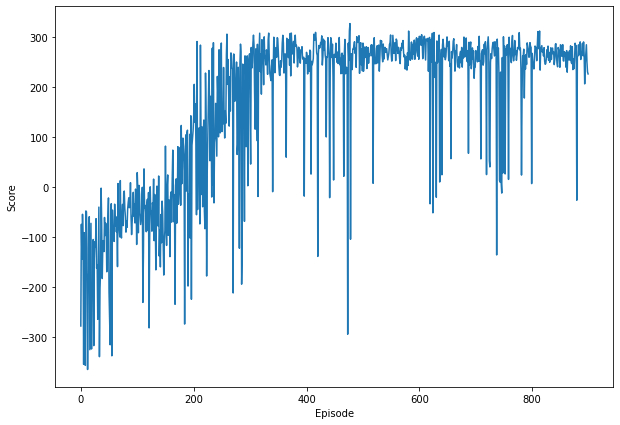

In [9]:
agent.train(episodes)